# Tutorial 4: Surrogate-Based Optimization

Our goal will be to train a neural network to predict the Rosenbrock function, defined as below, and then use the surrogate to find the minimum, located at $(1, 1)$. 

$
f(x_1, x_2) = (1 - x_1)^2 + 100 (x_2 - x_1^2)^ 2
$

### Settings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
import jenn
from typing import List, Tuple, Union, Callable
from jenn.utils import plot
from jenn.utils import metrics 
from jenn.utils.rbf import rbf

In [3]:
RANDOM_SEED = 123  
SHUFFLE = False

In [4]:
test_function = jenn.synthetic.Rosenbrock

### Support Functions

Since this is a two-dimensional function, we can compare the contour plots of the predicted and true response:

In [5]:
@jenn.utils.plot.requires_matplotlib 
def optimize(
        f: Callable,  
        dfdx: Callable,  
        x0: Tuple[float, float] = (1.25, -1.75), 
        alpha: float = .2, 
        max_iter: int = 100_000,
        ax: plt.Axes | None = None, 
        title: str = "", 
        levels: int = 100, 
        is_legend: bool = True, 
        beta_1: float = 0.9,
        beta_2: float = 0.99,
        tau: float = 0.5,
        tol: float = 1e-06,
        max_count: int = 1000,
        epsilon_absolute: float = 1e-12,  
        epsilon_relative: float = 1e-12, 
    ):
    """Check that optimizer yields correct answer for rosenbrock function."""
    
    # Initial guess
    x0 = np.array(x0).reshape((2, 1))

    # Optimization
    opt = jenn.core.optimization.ADAMOptimizer(
        beta_1, beta_2, tau, tol, max_count
    )
    xf = opt.minimize(
        x0, f, dfdx, 
        alpha=alpha, 
        max_iter=max_iter,
        epsilon_absolute=epsilon_absolute,  
        epsilon_relative=epsilon_relative, 
    )

    # For plotting contours
    lb = -2.
    ub = 2.
    m = 100
    x1 = np.linspace(lb, ub, m)
    x2 = np.linspace(lb, ub, m)
    X1, X2 = np.meshgrid(x1, x2)
    Y = np.zeros(X1.shape)
    for i in range(0, m):
        for j in range(0, m):
            X = np.array([
                [X1[i, j]],
                [X2[i, j]],
            ])
            Y[i, j] = f(X).squeeze()
        
    if ax is not None:
        x1_his = np.array([x[0] for x in opt.vars_history]).squeeze()
        x2_his = np.array([x[1] for x in opt.vars_history]).squeeze()
        ax.plot(x1_his, x2_his)
        ax.plot(x0[0], x0[1], '+', ms=15)
        ax.plot(xf[0], xf[1], 'o')
        ax.plot(np.array([1.]), np.array([1.]), 'x')
        if is_legend: 
            ax.legend(['history', 'initial guess', 'predicted optimum', 'true optimum'])
        ax.contour(X1, X2, Y, levels, cmap='RdGy')
        ax.set_title(title)

In [6]:
@jenn.utils.plot.requires_matplotlib 
def plot_contours(
    nn: jenn.model.NeuralNet, 
    genn: jenn.model.NeuralNet, 
    x0: Tuple[float, float] = (1.25, -1.75), 
    levels: int = 100,
    **kwargs, 
): 
    """Plot contours of True, JENN and NN side by side."""
    import matplotlib.pyplot as plt 
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    optimize(
        f=test_function.evaluate, 
        dfdx=test_function.first_derivative, 
        x0=x0,
        ax=ax[0],
        title="True", 
        levels=levels,
        **kwargs
    )
    optimize(
        f=genn.predict, 
        dfdx=genn.predict_partials, 
        x0=x0,
        ax=ax[1],
        is_legend=False,
        title="JENN",
        levels=levels,
        **kwargs
    )
    optimize(
        f=nn.predict, 
        dfdx=nn.predict_partials, 
        x0=x0,
        ax=ax[2], 
        is_legend=False, 
        title="NN",
        levels=levels,
        **kwargs
    )
    plt.close(fig)
    return fig

### Synthetic Data

Define the domain over which we will collect synthetic training data:

In [7]:
lb = (-2.0, -2.0)
ub = (2.0, 2.0)

We will now generate some synthetic data that will be used to train our GENN model later on:

In [8]:
x_train, y_train, dydx_train = test_function.sample(m_lhs=100, m_levels=17, lb=lb, ub=ub)

We also generate some synthetic data that will be used to test the accuracy of the trained model:

In [9]:
x_test, y_test, dydx_test = test_function.sample(m_lhs=1000, m_levels=0, lb=lb, ub=ub)

### Training 

For comparison, let's train two models: a regular neural network and gradient-enhanced neural network. 

#### Regular Neural Network

In [10]:
%%time
nn = jenn.model.NeuralNet(
    layer_sizes=[2] + [20] * 3 + [1],
).fit(
    x=x_train, 
    y=y_train, 
    alpha=1e-5, 
    lambd=1e-3, 
    is_normalize=True, 
    max_iter=75_000,
    random_state=RANDOM_SEED, 
    shuffle=SHUFFLE, 
)

CPU times: user 1min 52s, sys: 149 ms, total: 1min 52s
Wall time: 1min 52s


#### Gradient-Enhanced Neural Network

In [11]:
%%time
genn = jenn.model.NeuralNet(
    layer_sizes=[2] + [20] * 3 + [1],
).fit(
    x=x_train, 
    y=y_train, 
    dydx=dydx_train,
    alpha=1e-5, 
    lambd=1e-3,
    is_normalize=True, 
    max_iter=75_000,
    random_state=RANDOM_SEED, 
    shuffle=SHUFFLE, 
)

CPU times: user 2min 37s, sys: 149 ms, total: 2min 38s
Wall time: 2min 38s


#### Goodness of Fit

Upon convergence, let's check how well the model generalizes on test data. All else being equal, GENN generally outperforms NN.

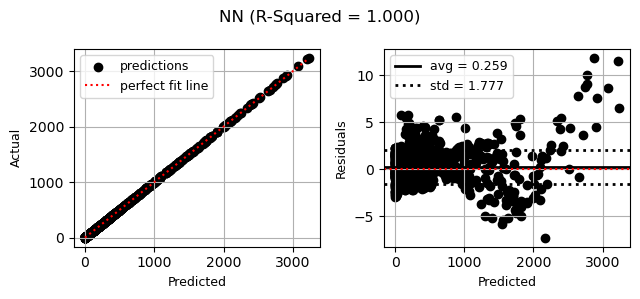

In [12]:
plot.goodness_of_fit(
    y_true=y_test, 
    y_pred=nn.predict(x_test),
    title="NN"
)

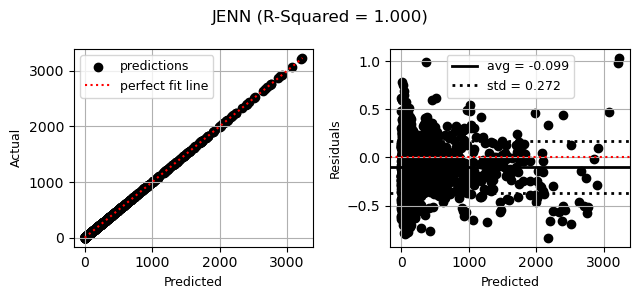

In [13]:
plot.goodness_of_fit(
    y_true=y_test, 
    y_pred=genn.predict(x_test),
    title="JENN"
)

#### Performance

##### Convergence Histories

It is good practice to check the convergence history in order to decide if we should keep training.

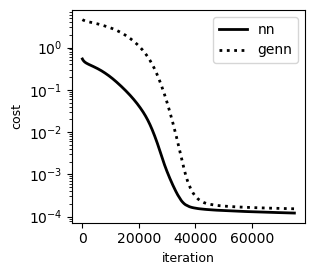

In [14]:
plot.convergence(histories=[nn.history, genn.history], legend=["nn", "genn"])

#### Surrogate-Based Optimization

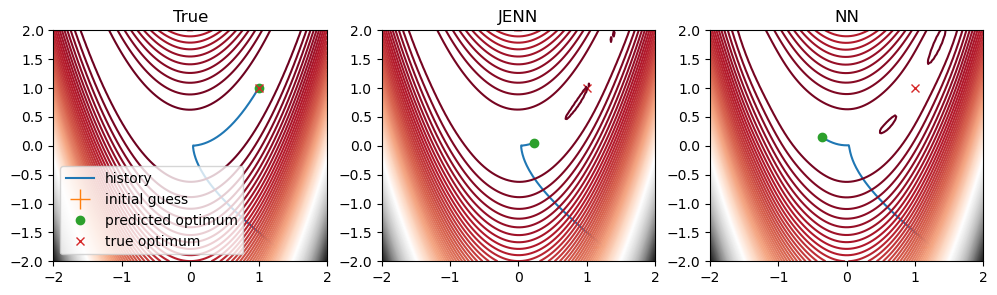

In [15]:
plot_contours(
    nn, 
    genn, 
    x0=(1.25, -1.75), 
    levels=100, 
    alpha=0.05, 
    beta_1=0.9,
    beta_2=0.99,
    tau=0.5,
    tol=1e-7,
    max_count=1000,
)

> Both surrogates did an excellent job capturing regions of large variation, providing accurate information to successfully lead the optimizer toward a valley of small numbers. However, both JENN and NN struggle to find a direction of improvement in that valley (eventhough JENN does better), eventually coming short of finding the optimum. For many engineering design applications, finding an answer that is close to the true optimum is often good enough. However, other design applications such airfoil shaping require better accuracy. In such situations, JENN offer a unique solution to ensure this through a process that will be termed polishing, discussed next. 

### Polishing  

Polishing starts from a previously trained model and continues training it using a "warm start." During cold start, by design, the optimizer focused on getting regions of large variation right, but loses momentum upon convergence since predicting very small values is within the noise of prediction error. This can be remedied by magnifying small errors and restarting the optimization process.  

#### Regular Neural Network

In [16]:
%%time
nn.fit(
    x=x_train, 
    y=y_train, 
    alpha=1e-6, 
    lambd=1e-3, 
    beta=1 + 1e3 * rbf(y_train, epsilon=0.1),  # magnify near-zero values
    is_normalize=True, 
    max_iter=200_000,
    random_state=RANDOM_SEED, 
    shuffle=SHUFFLE, 
    is_warmstart=True
)

CPU times: user 5min 10s, sys: 5.04 s, total: 5min 15s
Wall time: 5min 15s


#### Gradient-Enhanced Neural Network

In [17]:
%%time
genn.fit(
    x=x_train, 
    y=y_train, 
    dydx=dydx_train,
    alpha=1e-6, 
    lambd=1e-3,
    beta=1 + 1e3 * rbf(y_train, epsilon=0.1), # magnify near-zero values
    gamma=1 + 1e3 * rbf(dydx_train, epsilon=0.1), # magnify near-zero partials
    is_normalize=True, 
    max_iter=200_000,
    random_state=RANDOM_SEED, 
    shuffle=SHUFFLE, 
    is_warmstart=True
)

CPU times: user 7min 16s, sys: 1.61 s, total: 7min 17s
Wall time: 7min 18s


#### Performance

##### Convergence Histories

It is good practice to check the convergence history in order to decide if we should keep training.

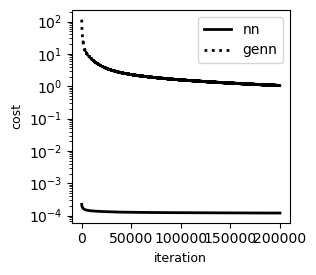

In [18]:
plot.convergence(histories=[nn.history, genn.history], legend=["nn", "genn"])

#### Surrogate-Based Optimization

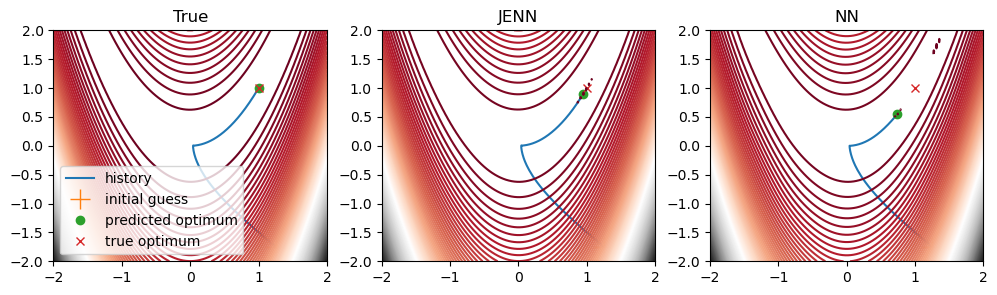

In [19]:
plot_contours(
    nn, 
    genn, 
    x0=(1.25, -1.75), 
    levels=100, 
    alpha=0.05, 
    beta_1=0.9,
    beta_2=0.99,
    tau=0.5,
    tol=1e-7,
    max_count=1000,
)